In [1]:
import sys

sys.path.append("./../..")

from numba import jit
from numba.types import bool_, int_
import numpy as np
import matplotlib.pyplot as plt
from InternalLibrary.StatisticalFunctions import stat_corr_single
from scipy.optimize import curve_fit
from scipy.stats import moment

from tqdm import tqdm

from sbi import analysis as analysis
from sbi import utils as utils
from sbi.inference import SNPE, simulate_for_sbi, infer
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)
import torch
import statistics

In [2]:
@jit
def RunTumble(param, dt=0.01, TotalT=1, alpha=0.5, keep_f = False):
    k = param[:,0]
    omega = param[:,1]
    n_sim = len(k)
    D = omega**2 / alpha
    
    total_time_steps = np.int64(TotalT / dt)
    
    x = np.zeros((1, n_sim))
    x_trace = np.zeros((n_sim, total_time_steps))
    
    direction = np.ones((1, n_sim))
    
    for n in range(1, total_time_steps):
        change = np.random.uniform(0, 1, size=(1, n_sim)) < alpha * dt / 2 # Change direction with probability alpha*dt/2
        change = -(change *2 -1) # From boolean to -1 or 1 (false = 1, true = -1)
        direction = change*direction # Change direction if change is true
        nu = np.random.normal(0, 1, size=(1, n_sim))
        x[:] = x[:] + (-k * x[:] + omega * direction) * dt + np.sqrt(2 * D * dt) * nu
        x_trace[:, n] = x[:,]

    return x_trace

def GenerateRawData(n_sim, prior_limits, simulator_param, simulator, test = False):
    # Define the number of parameters
    NumberOfParameters = len(prior_limits)
    
    # From prior dictionary to numpy array
    BoxLimits = np.zeros((2, NumberOfParameters))
    i = 0
    for item in prior_limits.items():
        BoxLimits[0, i] = item[1][0]
        BoxLimits[1, i] = item[1][1]
        i +=1
    BoxLimits = torch.tensor(BoxLimits)
    # Define the prior as a uniform box for each parameter
    prior = utils.BoxUniform(low=BoxLimits[0], high=BoxLimits[1])
    
    # Generate the data
    theta = prior.sample((n_sim,))
    if test:
        theta = torch.tensor([list(theta[0].numpy())]*n_sim)
    raw_trace = simulator(param = theta.numpy(), **simulator_param)
    
    return theta, raw_trace, prior

def ComputeSummaryStatistics(summary_statistics_to_calculate, raw_trace, available_statistics = {}, hyperparameters = {}):
    ## summary_statistics_to_calculate is a list of strings with the names of the summary statistics to calculate
    ## raw_trace is a numpy array with the raw data
    
    
    # Calculate the summary statistics
    final_vector = torch.zeros(0)
    for stat in summary_statistics_to_calculate:
        print(f"Computing {stat}...")
        final_vector = torch.cat((final_vector, torch.tensor(available_statistics[stat](raw_trace, hyperparameters = hyperparameters))))
    
    return final_vector

def SBIPipeline(prior_limits, simulator_param, summary_statistics_to_calculate, available_statistics, hyperparameters, n_sim = 1000):
    # Generate the raw data
    theta, raw_trace, prior = GenerateRawData(n_sim, prior_limits, simulator_param, RunTumble)
    stats = ComputeSummaryStatistics(summary_statistics_to_calculate, raw_trace, available_statistics, hyperparameters)
    stats = stats.float()
    # Set up SBI
    prior, num_parameters, prior_returns_numpy = process_prior(prior)
    infer = SNPE(prior=prior)
    
    inference = infer.append_simulations(theta, stats)
    density_estimator = inference.train()
    posterior = inference.build_posterior(density_estimator)
    
    return posterior

In [3]:
def Autocorrelation(multiple_raw_traces, hyperparameters = {}):
    
    if "DeltaT" in hyperparameters.keys():
        DeltaT = hyperparameters["DeltaT"]
    else:
        print("No DeltaT provided, assuming DeltaT = 1")
        DeltaT = 1
        
    if "sampling" in hyperparameters.keys():
        sampling = hyperparameters["sampling"]
    else:
        print("No sampling provided, assuming linear")
        sampling = "linear"
    
    if "n_points" in hyperparameters.keys():
        n_points = hyperparameters["n_points"]
    else:
        print("No n_points provided, assuming 100")
        n_points = 100
    
    
    autocorr = stat_corr_single(multiple_raw_traces[0,:], 1) .reshape(1,-1)
    for i in np.arange(1,multiple_raw_traces.shape[0]):
        autocorr = np.vstack((autocorr, stat_corr_single(multiple_raw_traces[i,:], DeltaT)))
        
    if sampling == "linear":
        autocorr = autocorr[:,np.linspace(0,autocorr.shape[1]-1,n_points).astype(int)]
    elif sampling == "log":
        autocorr = autocorr[:,np.logspace(0,np.log10(autocorr.shape[1]-1),n_points).astype(int)]
    elif sampling == "fit":
        autocorr = FitAutocorrelationFunctions(autocorr, DeltaT)
    elif sampling == "all":
        pass
    return autocorr

def FitAutocorrelationFunctions(multiple_corr_traces, DeltaT):
    """
    Fit an exponential function to the autocorrelation functions with formula a*exp(-b*x)
    """
    def func(x, a, b):
        return a * np.exp(-b * x)
    
    output = np.zeros((multiple_corr_traces.shape[0], 2))
    for i in range(multiple_corr_traces.shape[0]):
        x = np.arange(0,multiple_corr_traces.shape[1]*DeltaT, DeltaT)
        popt, pcov = curve_fit(func, x, multiple_corr_traces[i,:])
        output[i,:] = popt
    return output
    
def TheoreticalAutocorrelation(D, k, alpha, omega, t, t1):
    return np.exp(-k (t - t1)) * ((D/k) * (1 - np.exp(-2*k*t1)) +2*omega**2*(np.exp(-2*k*t1) * 1/(2 * k *(k-alpha))) + np.exp(-(k+alpha)*t1)*1/((k+alpha)*(alpha-k)) + 1/(2*k*(k + alpha))) + omega/(k + alpha) * (1 - np.exp(-(k+alpha)*(t-t1))) * (omega / (k + alpha) * (1 - np.exp(-(k+alpha)*t1)))

In [4]:
prior_limits = {"k" : [0,5], "omega": [0,5]}
simulator_param = {"dt":0.01, "TotalT":1, "alpha":0.5}
summary_statistics_to_calculate = ["Autocorrelation"]
available_statistics = {"Autocorrelation": Autocorrelation}
hyperparameters = {"DeltaT":0.01, "sampling":"fit", "n_points":100}
n_sim = 10000

posterior = SBIPipeline(prior_limits, simulator_param, summary_statistics_to_calculate, available_statistics, hyperparameters, n_sim = n_sim)

Computing Autocorrelation...
 Neural network successfully converged after 124 epochs.

Computing Autocorrelation...


Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

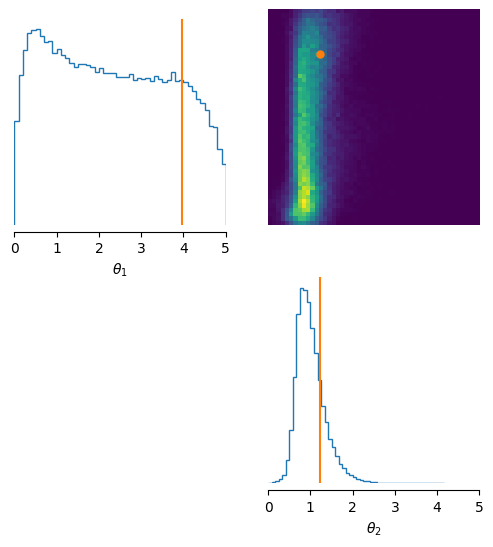

In [36]:
n_test = 1
theta_test, trace_test, prior = GenerateRawData(n_test, prior_limits, simulator_param, RunTumble)
stats_test = ComputeSummaryStatistics(summary_statistics_to_calculate, trace_test, available_statistics, hyperparameters)

samples = posterior.sample((100000,), x=stats_test)
_ = analysis.pairplot(samples, points=theta_test, limits=[[0.0, 5.], [0, 5.]], figsize=(6, 6), labels=[r"$\theta_1$", r"$\theta_2$"])

#print(f"Theta1 mode: {statistics.mode(samples[:,0]):.2f}, theta1 true: {theta_test[0][0]:.2f}\nTheta2 mode: {statistics.mode(samples[:,1]):.2f}, theta2 true: {theta_test[0][1]:.2f}")

# Summary Statistics Robustness

## Autocorrelation

In [6]:
# Generate a bunch of data with the same parameters and compute the autocorrelation
prior_limits = {"k" : [0,5], "omega": [0,5]}
simulator_param = {"dt":0.001, "TotalT":10, "alpha":0.5}
summary_statistics_to_calculate = ["Autocorrelation"]
available_statistics = {"Autocorrelation": Autocorrelation}
hyperparameters = {"DeltaT":0.001, "sampling":"fit", "n_points":100}
n_sim = int(1e4)
theta, raw_trace, prior = GenerateRawData(n_sim, prior_limits, simulator_param, RunTumble, test = True)
stats = ComputeSummaryStatistics(summary_statistics_to_calculate, raw_trace, available_statistics, hyperparameters)
stats = stats.numpy()

Computing Autocorrelation...


a: 10.80 ± 3.00
b: 4.52 ± 1.98


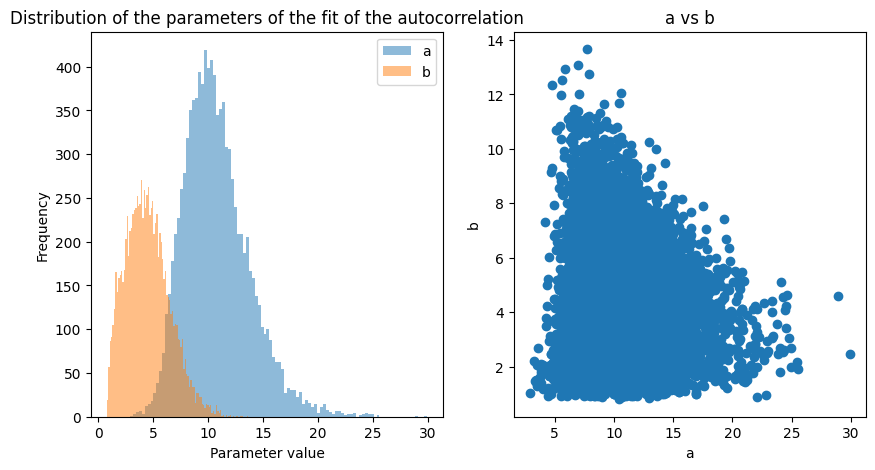

In [7]:
# Plot the distribution of the parameters of the fit of the autocorrelation

fig, ax = plt.subplots(1,2, figsize = (10,5))
ax[0].hist(stats[:,0], bins = 100, alpha = 0.5)
ax[0].hist(stats[:,1], bins = 100, alpha = 0.5)
ax[0].set_xlabel("Parameter value")
ax[0].set_ylabel("Frequency")
ax[0].legend(["a", "b"])
ax[0].set_title("Distribution of the parameters of the fit of the autocorrelation")
#ax.text(86, 850, "Formula: $ae^{-bt}$", usetex = True)

ax[1].scatter(stats[:,0], stats[:,1])
ax[1].set_xlabel("a")
ax[1].set_ylabel("b")
ax[1].set_title("a vs b")


print(f"a: {np.mean(stats[:,0]):.2f} ± {np.std(stats[:,0]):.2f}\nb: {np.mean(stats[:,1]):.2f} ± {np.std(stats[:,1]):.2f}")